# Morison equation with irregular waves

Force on a submerged body in oscillatory flow can be split into the following terms
$$
F = F_{D} + F_{FK} + F_{AM}
$$

$F_{D}$ = Drag due to viscous effects <br>
$F_{FK}$ = Froude-Krylov force, due to the pressure gradient under the oscillatory flow. <br>
$F_{AM}$ = Hydrodynamic Mass / Added Mass, due to the acceleration of surrounding fluid.

For a cylindrical body <br>
$F_{D} =  \frac{1}{2} C_d \times \rho D u |u| $ <br>
$F_{FK} = \rho A \dot{u}$ <br>
$F_{AM} = C_m \times \rho A \dot{u}$

$F =  \frac{1}{2} C_d \times \rho D u |u| + (1+C_m) \rho A \dot{u}$ <br>
$C_I = 1 + C_M$

Note that $F_D$ is nonlinear. Therefore, it will not be possible to linearly superimpose the force due to various wave components.
However, we can superimpose the velocity field due to each wave frequency in the spectrum. 
This notebook will teach you how to construct a irregular wave time-series and then how to use that to calculate force on a submerged body using Morison's equation. 


## Install MHKiT for generating spectrum

We use the following package to generate the JONSWAP spectrum

https://mhkit-software.github.io/MHKiT/index.html

Install it using `pip`
Ignore warnings

In [52]:
pip install mhkit

Note: you may need to restart the kernel to use updated packages.


In [53]:
pip install git+https://github.com/CMOE-TUDelft/FSSLibrary


  Cloning https://github.com/CMOE-TUDelft/FSSLibrary to /tmp/pip-req-build-19wfsvqx
  Running command git clone --filter=blob:none --quiet https://github.com/CMOE-TUDelft/FSSLibrary /tmp/pip-req-build-19wfsvqx
  Resolved https://github.com/CMOE-TUDelft/FSSLibrary to commit 8936ab87b635effa6cae2b397520818e68ab3ad9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


## Define constants

In [54]:
import numpy as np
import math as math
import time
from scipy import interpolate
from scipy import optimize
import pandas as pd
import mhkit
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
pass

In [55]:
g = 9.81 #m/s2
rhoW = 1000 #kg/m3

## Define cylindrical structures

In [56]:
class Cyl:
    def __init__(self, x0, z0, R, dth):
        thMat = np.arange(0, 360, dth) #deg
        cx = x0 + R*np.cos( np.deg2rad(thMat) )
        cz = z0 + R*np.sin( np.deg2rad(thMat) )
        self.R = R
        self.D = 2*R
        self.x0 = x0
        self.z0 = z0
        self.cx = cx
        self.cz = cz
        self.NodeC = [ [x, z] for x,z in zip (cx, cz) ]
        self.nNode = len(self.NodeC)
        self.Ele = [ [n1, n2] for n1,n2 in 
                    zip( range(0,self.nNode-1), range(1,self.nNode)) ]
        self.Ele.append([self.nNode-1, 0])
        self.nEle = len(self.Ele)
        self.P = np.zeros(self.nNode)
        
    def plotEle(self):
        for iEle in range(0,self.nEle):
            n1, n2 = self.Ele[iEle]
            n1 = int(round(n1))
            n2 = int(round(n2))
            plt.plot( [self.NodeC[n1][0], self.NodeC[n2][0]],
                     [self.NodeC[n1][1], self.NodeC[n2][1]],
                     lw=3, color='k')
            
        
# Cyl(x0, z0, R, dthDeg):

## Generating wave spectrum using MHKiT

In [57]:
def get_spec(w, Tp, Hs):
    freq = w/2/np.pi
    q = mhkit.wave.resource.jonswap_spectrum(freq, Tp, Hs)
    return q.to_numpy()/2/np.pi

51.37052798911338


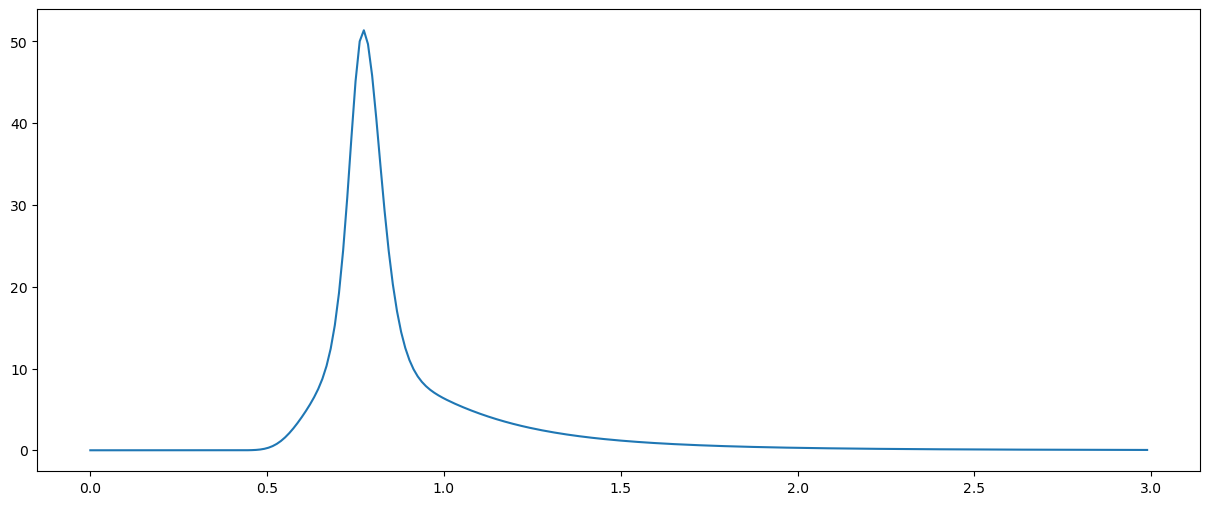

In [58]:
Hm0 = 12.831; Tp = 8.145;
# spec = pd.read_csv("spec_Hs6.5_Tp7.5.csv", header=None)

w = np.arange(00.000001,3,3/256) #Angular frequency
S = get_spec(w, Tp, Hm0)

ns=1200
dt=0.1
plt.figure()
plt.plot(w, S)
print(np.max(S))
plt.show()

### Get amplitude spectrum from power spectral density function

Definition of single-sided power spectral density function is given by
$$
\sum_f^{f+\Delta f} \frac{1}{2} a_n^2 = S_n(f) \Delta f \quad
$$
PSDF has a unit of $m^2 \cdot s$

The single-sided amplitude spectrum is given by 
$$
a_n(f) = \sqrt{2 S_n(f) \Delta f}
$$

Here `S.args`$= \omega$ and `S.data`= Spectral density value

In [59]:
def getAmpSpec(w, E, iseed=None):    
    df = w[1]-w[0]
    A = np.sqrt(2*E*df)
    nw = len(w)
    
    # Seed for random phase    
    if iseed is not None:
        try:
            np.random.set_state(iseed)
        except (KeyError, TypeError):
            np.random.seed(iseed)
    ph = np.random.rand(nw) * 2 * np.pi - np.pi
    return A[2:], w[2:], ph[2:]

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_588954/4131924177.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$\omega$ (rad/s)')
/tmp/ipykernel_588954/4131924177.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\eta_0$ (m)')


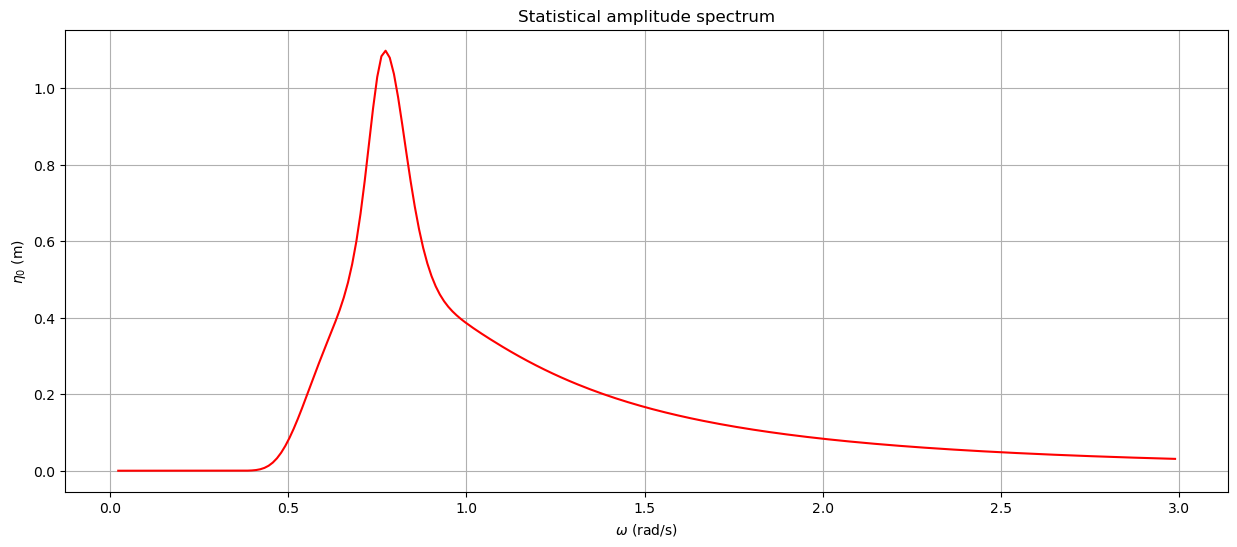

In [60]:
A, w, ph = getAmpSpec(w, S, iseed=123)
# A, w, ph = getAmpSpec(spec, ns//2+1, iseed=123)

plt.figure()
plt.plot(w, A, color='r')
plt.title('Statistical amplitude spectrum')
plt.xlabel('$\omega$ (rad/s)')
plt.ylabel('$\eta_0$ (m)')
plt.grid('on')
plt.show()
pass

## Define Case

We use `LinearWave2D` class from `LinearWave` package for defining the linear wave and the associated particle velocity, acceleration and pressure fields.

The linear wave theory only calculate the pressure and velocities for $z<=0$. <br> In order to calculate the values for $z>0$ we use

- For Pressure: Taylor series expansion, limited to first order
- For Velocities: Wheeler stretching [link](https://www.orcina.com/webhelp/OrcaFlex/Content/html/Waves,Kinematicstretching.htm#:~:text=Wheeler%20stretching,at%20the%20instantaneous%20water%20surface.)

We initiate `LineaerWave` object using amplitudes from JONSWAP spectrum and random phase. This will be used for obtaining the elevation, velocity and acceleration time-series for calculating the forces.

### Documentation of `LinearWave2D`

We have two classes

- `LinearWave2D`: Class to define wave in shallow water
    - `wv = LinearWave2D(rhoW, g, d, T, H)`
    - `rhoW`: Density of water
    - `g`: acceleration due to gravity
    - `d`: still-water depth
    - `T`: Wave time-period
    - `H`: Wave-height

- `LinearWaveDeep2D`: Class to define wave in deep water
    - `wv = LinearWave2D(rhoW, g, T, H)`
    - `rhoW`: Density of water
    - `g`: acceleration due to gravity
    - `T`: Wave time-period
    - `H`: Wave-height


Location in 2D space is defined as `(x,z)`
The time instant is `t`

- `wv.waveElevation(t,x)` : Wave elevation at a given x
- `wv.pressureTot(t,x,z)` : Total pressure (static + dynamic pressure)
- `wv.pressureDyn(t,x,z)` : Dynamic pressure
- `wv.particleVelPoi(t,x,z)` : Wave particle vel at (x,z) at time-instant t
- `wv.particleAccPoi(t,x,z)` : Wave particle acceleration at (x,z) at time-instant t
- `wv.particleVelMax(t,x,z)` : Maximum of wave particle vel at location (x,z)
- `wv.particleAccMax(t,x,z)` : Maximum of wave particle acceleration at location (x,z)

Here `wv` can be an object of `LinearWave2D` or `LinearWaveDeep2D`

In [61]:
from FSSLibrary.LinearWave import LinearWave2D
from FSSLibrary.LinearWave import LinearWaveDeep2D

# Cyl(x0, z0, R, dthDeg):
cyl1 = Cyl(10, -20, 5, 0.1)

# Wave(g, d, T, H, phi=0, x0=0)
d = 187 #m (still-water depth)

# Create an array of LinearWave2D objects
# wvAll = [ LinearWave2D(rhoW, g, d, 2*np.pi/wi, 2*Ai, phi, msg=False) for wi,Ai,phi in zip(w,A,ph) ]
# wvRAO = [ LinearWave2D(rhoW, g, d, 2*np.pi/wi, 2*1.0, phi, msg=False) for wi,phi in zip(w,ph) ]
# wvTest = [ LinearWave2D(rhoW, g, d, 2*np.pi/wi, 2*1.0, phi, msg=False) for wi,Ai,phi in zip(w[100:102],A[100:102],ph[100:102]) ]

wvAll = [ LinearWaveDeep2D(rhoW, g, 2*np.pi/wi, 2*Ai, phi, msg=False) for wi,Ai,phi in zip(w,A,ph) ]

## Calculate elevation, velocities and acceleration from spectrum

In [62]:
def spec2ts(wvListIn, x0, z0, t):
    nt = len(t)
    et_t = np.zeros(nt)
    vx_t = np.zeros(nt)
    vz_t = np.zeros(nt)
    vm_t = np.zeros(nt)
    ax_t = np.zeros(nt)
    az_t = np.zeros(nt)
    
    for i, ti in enumerate(t):
        et_t[i] = sum([wv.waveElevation(ti, x0) for wv in wvListIn])
        vel = np.array([wv.particleVelPoi(ti, x0, z0) for wv in wvListIn])
        vx_t[i] = np.sum(vel[:, 0])
        vz_t[i] = np.sum(vel[:, 1])
        vm_t[i] = np.sqrt( vx_t[i]**2 + vz_t[i]**2 )
        acc = np.array([wv.particleAccPoi(ti, x0, z0) for wv in wvListIn])
        ax_t[i] = np.sum(acc[:, 0])
        az_t[i] = np.sum(acc[:, 1])
    
    return et_t, vx_t, vz_t, vm_t, ax_t, az_t

In [63]:
st = time.time()
t_t = dt*np.arange(0,ns)
et_t, vx_t, vz_t, vm_t, ax_t, az_t = spec2ts(wvAll, cyl1.x0, cyl1.z0, t_t)
print('Elapsed time = ', time.time()-st, ' s')

/tmp/ipykernel_588954/1358856353.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  et_t[i] = sum([wv.waveElevation(ti, x0) for wv in wvListIn])


Elapsed time =  7.171838045120239  s


<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_588954/574070137.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\eta$ (m)')
/tmp/ipykernel_588954/574070137.py:23: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$\dot{v}$ (m/s2)')


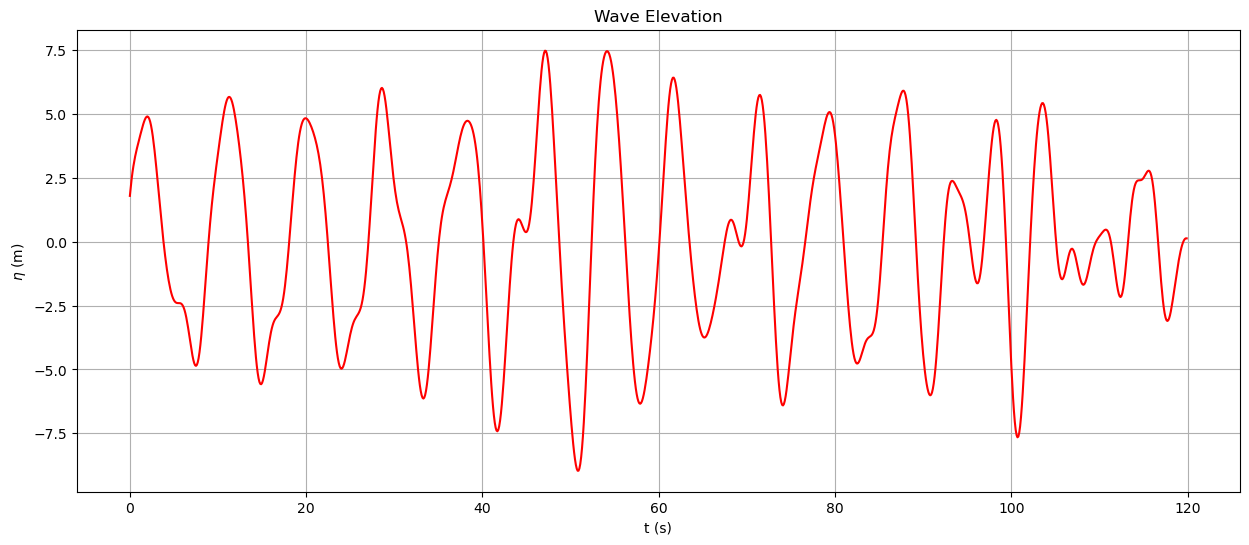

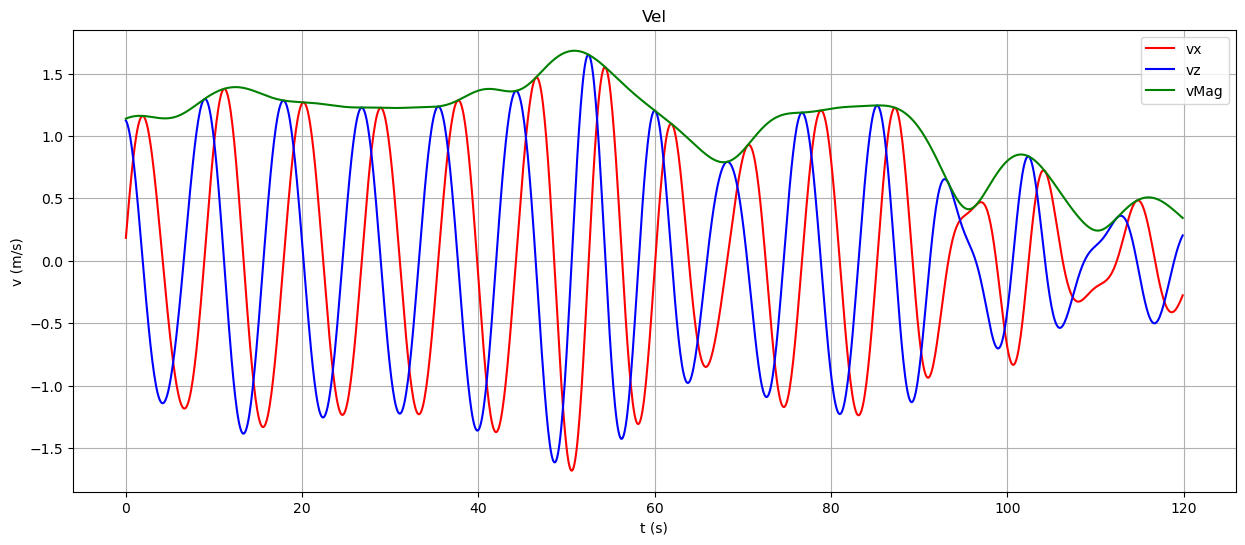

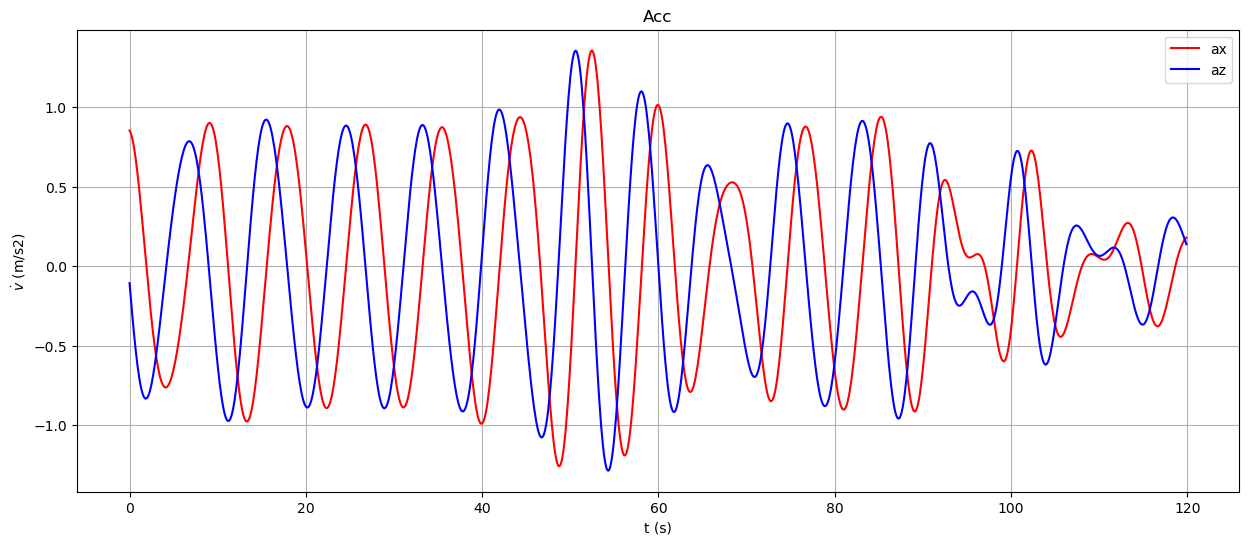

In [64]:
plt.figure()
plt.plot(t_t, et_t, color='r')
plt.title('Wave Elevation')
plt.xlabel('t (s)')
plt.ylabel('$\eta$ (m)')
plt.grid('on')

plt.figure()
plt.plot(t_t, vx_t, color='r', label='vx')
plt.plot(t_t, vz_t, color='b', label='vz')
plt.plot(t_t, vm_t, color='g', label='vMag')
plt.title('Vel')
plt.xlabel('t (s)')
plt.ylabel('v (m/s)')
plt.grid('on')
plt.legend()

plt.figure()
plt.plot(t_t, ax_t, color='r', label='ax')
plt.plot(t_t, az_t, color='b', label='az')
plt.title('Acc')
plt.xlabel('t (s)')
plt.ylabel('$\dot{v}$ (m/s2)')
plt.grid('on')
plt.legend()

plt.show()
pass

## Calculate force amplitude using particle acceleration

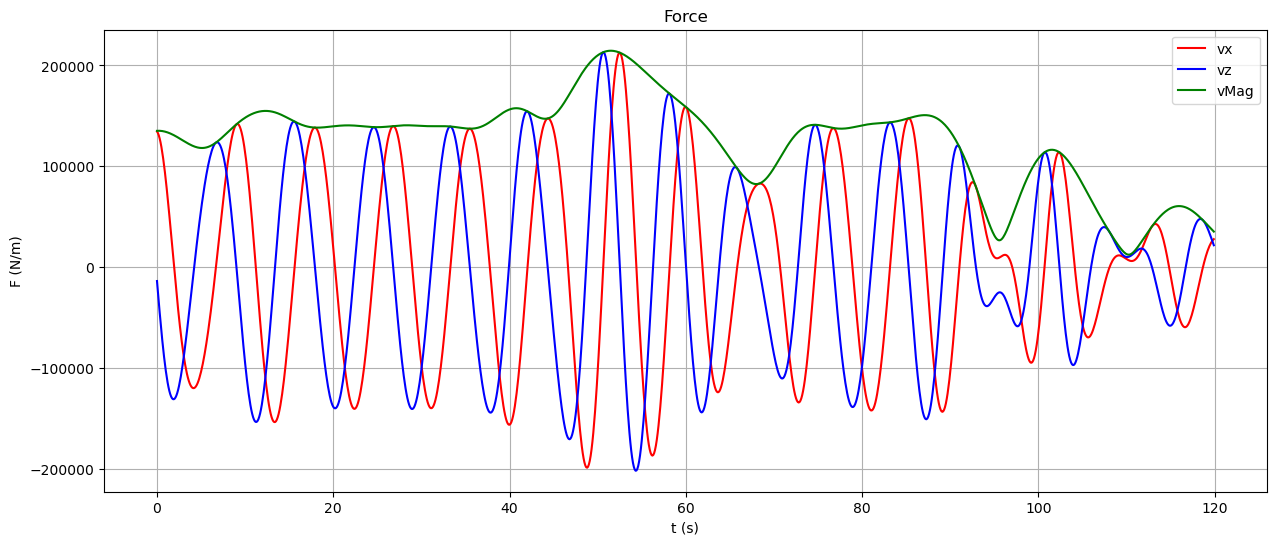

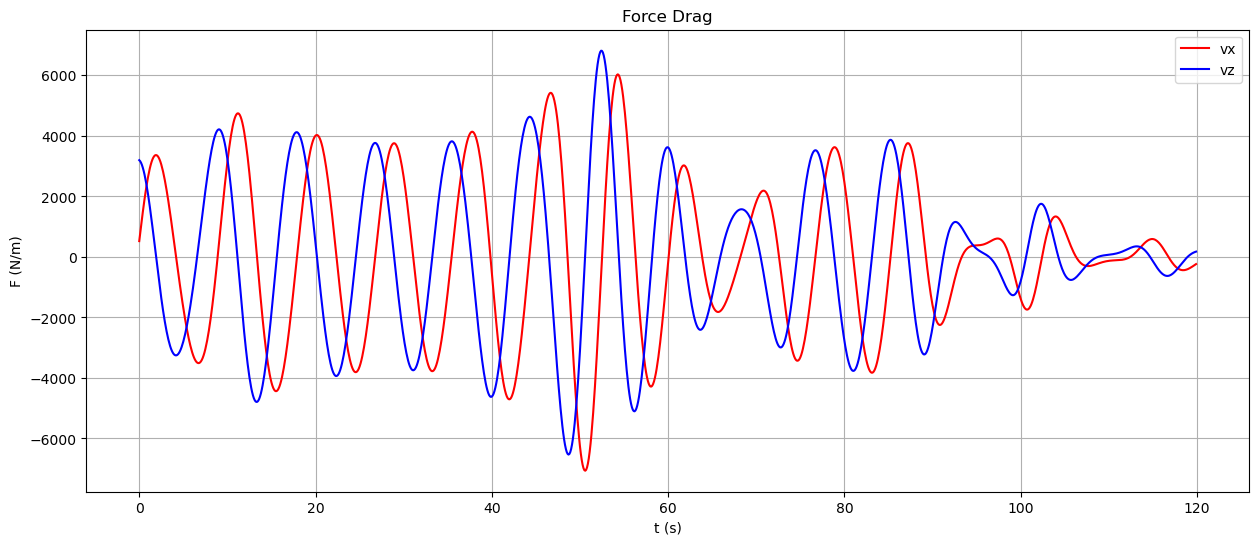

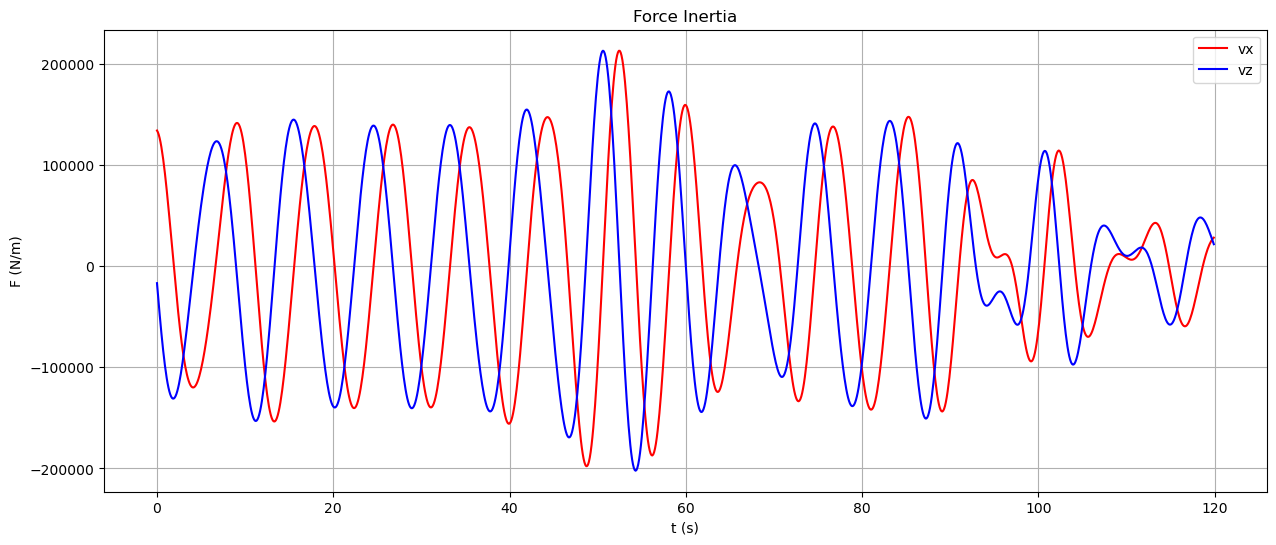

In [65]:
CI = 2.0 #(Total coefficient for inertia)
CD = 0.5 #(Drag coefficient)

cnstFD = 0.5*CD*rhoW*cyl1.D
cnstFI = CI*rhoW*np.pi*cyl1.R**2

FxD_t = [ cnstFD*vx*vm for vx,vm,ax in zip(vx_t, vm_t, ax_t) ]
FzD_t = [ cnstFD*vz*vm for vz,vm,az in zip(vz_t, vm_t, az_t) ]

FxI_t = [  cnstFI*ax for ax in ax_t ]
FzI_t = [  cnstFI*az for az in az_t ]


Fx_t = [ cnstFD*vx*vm + cnstFI*ax for vx,vm,ax in zip(vx_t, vm_t, ax_t) ]
Fz_t = [ cnstFD*vz*vm + cnstFI*az for vz,vm,az in zip(vz_t, vm_t, az_t) ]
Fm_t = [ np.sqrt(fx**2+fz**2) for fx,fz in zip(Fx_t,Fz_t) ]

plt.figure()
plt.plot(t_t, Fx_t, color='r', label='vx')
plt.plot(t_t, Fz_t, color='b', label='vz')
plt.plot(t_t, Fm_t, color='g', label='vMag')
plt.title('Force')
plt.xlabel('t (s)')
plt.ylabel('F (N/m)')
plt.grid('on')
plt.legend()

plt.figure()
plt.plot(t_t, FxD_t, color='r', label='vx')
plt.plot(t_t, FzD_t, color='b', label='vz')
plt.title('Force Drag')
plt.xlabel('t (s)')
plt.ylabel('F (N/m)')
plt.grid('on')
plt.legend()


plt.figure()
plt.plot(t_t, FxI_t, color='r', label='vx')
plt.plot(t_t, FzI_t, color='b', label='vz')
plt.title('Force Inertia')
plt.xlabel('t (s)')
plt.ylabel('F (N/m)')
plt.grid('on')
plt.legend()

plt.show()

pass